In [276]:
import pandas as pd
import numpy as np
import ast 
import json
import requests
from datetime import datetime
from datetime import date
import os
import sys
import time
import math
from thefuzz import fuzz
import matplotlib.pyplot as plt

In [111]:
# Set your API key here
API_KEY = 'Vz7nSide5OocT948BbImlJTkCKREvs6mrTBf2AL5'
# S3 bucket url base + s3Path (in get request) = the full path to the files
####### Streaming services API #######
# This is an example of how to use the streaming services API to get hourly emissions data.

# Use this API for continuous data streams and avoiding paging through results.

# api parameters for the streaming emissions/apportioned/hourly endpoint

for k in range(7,22):
    main_df = []
    if k<0:
        k_str = '199'+str(10+k)
    elif 0<=k<10:
        k_str = '200'+str(k)
    else:
        k_str = '20'+str(k)
    for j in range(1,13):
        for i in range(1,32):
            if (i<10) & (j<10):
                parameters = {
                    'api_key': API_KEY,
                    'beginDate': k_str+'-0'+str(j)+'-0'+str(i),
                    'endDate': k_str+'-0'+str(j)+'-0'+str(i),
                }
            elif (i<10) & (j>=10):
                parameters = {
                    'api_key': API_KEY,
                    'beginDate': k_str+'-'+str(j)+'-0'+str(i),
                    'endDate': k_str+'-'+str(j)+'-0'+str(i),
                }
            elif (i>=10) & (j<10):
                parameters = {'api_key': API_KEY,
                    'beginDate': k_str+'-0'+str(j)+'-'+str(i),
                    'endDate': k_str+'-0'+str(j)+'-'+str(i),
                }
            else:
                parameters = {'api_key': API_KEY,
                    'beginDate': k_str+'-'+str(j)+'-'+str(i),
                    'endDate': k_str+'-'+str(j)+'-'+str(i),
                }
    
            if ((j==2)&(i>=29))|((j==4)&(i>=31))|((j==6)&(i>=31))|((j==9)&(i>=31))|((j==11)&(i>=31)):
                continue
            
            
            date_format = "%Y-%m-%d"
            beginDate = datetime.strptime(parameters['beginDate'], date_format)
            endDate = datetime.strptime(parameters['endDate'], date_format)
            if (endDate - beginDate).days > 31:
                warnings.warn("The request you're making could be too large for the streaming services API and may result in a bad request. Please consider using the bulk data api endpoint instead. An example can be found in the bulk_data_demo.py file.")


            max_retries = 10
            retry_delay = 3  # seconds
            streamingUrl = "https://api.epa.gov/easey/streaming-services/emissions/apportioned/hourly"
            
            for attempt in range(max_retries):
                try:
                    streamingResponse = requests.get(streamingUrl, params=parameters)
                    json_data = streamingResponse.json()
            
                    # Check if the JSON is a list (what we expect from a successful response)
                    if (isinstance(json_data, list))&(len(json_data)>1): 
                        break  # Exit loop if good data received
                    else:
                        print(f"Unexpected format on attempt {attempt+1}, retrying...")
            
                except ValueError as e:
                    print(f"JSON decoding failed on attempt {attempt+1}: {e}")
            
                # If we haven't broken out, wait and retry
                time.sleep(retry_delay)
            else:
                print(f"Failed to get valid data after {max_retries} attempts")
                continue  # Skip this iteration in the main loop
            
            # Now you can safely use json_data
            streamingResponse_df = pd.DataFrame(json_data)
            # making get request using the emissions/apportioned/hourly endpoint
            
            

            print(f"Date: {parameters['beginDate']}")
            #print("JSON response preview:", streamingResponse.json()[:3])  # Just show a few entries
            print("Length of JSON response:", len(json_data))
            
            # printing the response error message if the response is not successful
            print("Status code: "+str(streamingResponse.status_code))
            if (int(streamingResponse.status_code) > 399):
                sys.exit("Error message: "+streamingResponse.json()['error']['message'])
            
            #print("Field Mappings: "+str(streamingResponse.headers['X-Field-Mappings']))
            ## the upper line is for printing the list of columns
            # collecting data as a data frame
            streamingResponse_df = pd.DataFrame(streamingResponse.json())
            df_filtered = streamingResponse_df.loc[streamingResponse_df["opTime"] == 1]
            df_filtered = df_filtered.drop(["associatedStacks", "so2Mass","so2MassMeasureFlg","so2Rate","so2RateMeasureFlg",\
                                           "co2Mass","co2MassMeasureFlg","co2Rate","co2RateMeasureFlg","noxMass",\
                                           "noxMassMeasureFlg","noxRate","noxRateMeasureFlg","heatInputMeasureFlg",\
                                           "so2ControlInfo","noxControlInfo","pmControlInfo","hgControlInfo","programCodeInfo"], axis=1)
            main_df.append(df_filtered)
    df_result = pd.concat(main_df, ignore_index=True)
    ### in case wanted to say the data in excel format, it might get to size of 10-11 meg for each year
    ### I don't think all of it can be saved in one excel file
    chunk_size = 1000000
    num_chunks = math.ceil(len(df_result) / chunk_size)
    
    for ii in range(num_chunks):
        start = ii * chunk_size
        end = start + chunk_size
        if end > len(df_result):
            end = len(df_result)
        df_chunk = df_result.iloc[start:end]
        save_path = "~/Documents/GitHub/AMR-project/hourly datasets/year"+str(k)+"-"+str(ii)+".xlsx"
        df_chunk.to_excel(save_path, index=False, engine="openpyxl")

Date: 2007-01-01
Length of JSON response: 91104
Status code: 200
Date: 2007-01-02
Length of JSON response: 91104
Status code: 200
Date: 2007-01-03
Length of JSON response: 91104
Status code: 200
Date: 2007-01-04
Length of JSON response: 91104
Status code: 200
Date: 2007-01-05
Length of JSON response: 91104
Status code: 200
Date: 2007-01-06
Length of JSON response: 91104
Status code: 200
Date: 2007-01-07
Length of JSON response: 91104
Status code: 200
Date: 2007-01-08
Length of JSON response: 91104
Status code: 200
Date: 2007-01-09
Length of JSON response: 91104
Status code: 200
Date: 2007-01-10
Length of JSON response: 91104
Status code: 200
Date: 2007-01-11
Length of JSON response: 91104
Status code: 200
Date: 2007-01-12
Length of JSON response: 91104
Status code: 200
Date: 2007-01-13
Length of JSON response: 91104
Status code: 200
Date: 2007-01-14
Length of JSON response: 91104
Status code: 200
Date: 2007-01-15
Length of JSON response: 91104
Status code: 200
Date: 2007-01-16
Length o

## what do next?
I think one thing that would be good to do ist to add another column of capacity of each generator, and then we would only keep observations with $\frac{gen}{cap}$ between $85-95\%$, or we  can also have efficiency dispersion histogram the same as Omer's

/tmp/ipykernel_1365841/3768001295.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  stata_cw_1stmerge.loc[stata_cw_1stmerge['name_match']>50,"bad match"] =0


In [458]:
stata_data = pd.read_stata('~/Documents/GitHub/AMR-project/hourly datasets/fossil_PlantCapacity_allyears.dta')
stata_data = stata_data[stata_data['Namecap_plant']>=20]
stata_data.loc[stata_data['PlantName']==""]
#(stata_cw_1stmerge["no plant ID"]==1)*(stata_cw_1stmerge["CAMD_STATE"]!=stata_cw_1stmerge["State"])
#float(crosswalk_data['EIA_PLANT_ID'])
temp=stata_cw_1stmerge[stata_cw_1stmerge["bad match"].astype(int)==1]
temp
#temp[temp["CAMD_PLANT_ID" ]==228]
#(stata_cw_1stmerge["State"]=="")|(stata_cw_1stmerge["State"].isna())
#stata_cw_1stmerge.loc[1,]\
#stata_cw_1stmerge['name_match']>50

,PlantID,CAMD_PLANT_ID,name_match,bad match,CAMD_STATE,State,CAMD_FACILITY_NAME,PlantName,CAMD_FUEL_TYPE,Enertype1,no plant ID
1590,3176.0,3176,50,True,PA,PA,Hunlock Creek Energy Center,Hunlock Power Station,Coal,Natural Gas,1.0
2351,7737.0,7737,30,True,SC,SC,"WestRock Charleston Kraft, LLC",Cogen South,Natural Gas,Coal,1.0
2354,7737.0,7737,32,True,SC,SC,"WestRock Charleston Kraft, LLC",Kapstone,Natural Gas,Biofuels & waste,1.0
2355,7737.0,7737,32,True,SC,SC,"WestRock Charleston Kraft, LLC",Kapstone,Natural Gas,Coal,1.0
2695,10381.0,10381,28,True,NC,NC,"Duplin BioEnergy, LLC",Green Power Kenansville,Biofuels & waste,Coal,1.0
2714,10474.0,10474,33,True,IN,IN,ArcelorMittal USA - Indiana Harbor East,4 AC Station,Other Gas,Coal,1.0
2810,10866.0,10866,49,True,IL,IL,"BioUrja Renewables - Peoria, IL",Archer Daniels Midland Peoria,Natural Gas,Coal,1.0
2813,10867.0,10867,32,True,IL,IL,Tate & Lyle,Primient Decatur Plant Cogen,Coal,Natural Gas,1.0
2855,50244.0,50244,28,True,NC,NC,Blue Ridge Paper Products Inc.,Canton North Carolina,Coal,Biofuels & waste,1.0
2885,50397.0,50397,29,True,PA,PA,Pixelle Specialty Solutions,P H Glatfelter,Coal,Natural Gas,1.0


In [466]:
stata_data = pd.read_stata('~/Documents/GitHub/AMR-project/hourly datasets/fossil_PlantCapacity_allyears.dta')
stata_data = stata_data[stata_data['Namecap_plant']>=20]
load_path = "~/Documents/GitHub/AMR-project/hourly datasets/"+"epa_eia_crosswalk"+".xlsx"
crosswalk_data = pd.read_excel(load_path,sheet_name="epa_eia_crosswalk", index_col=0)

crosswalk_data.loc[crosswalk_data["CAMD_FUEL_TYPE"]=="Wood","CAMD_FUEL_TYPE"] = "Biofuels & waste"
crosswalk_data.loc[crosswalk_data["CAMD_FUEL_TYPE"]=="Diesel Oil","CAMD_FUEL_TYPE"] = "Petroleum"
crosswalk_data.loc[crosswalk_data["CAMD_FUEL_TYPE"]=="Diesel Oil","CAMD_FUEL_TYPE"] = "Petroleum"
crosswalk_data.loc[crosswalk_data["CAMD_FUEL_TYPE"]=="Pipeline Natural Gas","CAMD_FUEL_TYPE"] = "Natural Gas"
crosswalk_data.loc[crosswalk_data["CAMD_FUEL_TYPE"]=="Process Gas","CAMD_FUEL_TYPE"] = "Other Gas"
crosswalk_data.loc[crosswalk_data["CAMD_FUEL_TYPE"]=="Residual Oil","CAMD_FUEL_TYPE"] = "Petroleum"
crosswalk_data.loc[crosswalk_data["CAMD_FUEL_TYPE"]=="Tire Derived Fuel","CAMD_FUEL_TYPE"] = "Tire-derived fuels"

crosswalk_data["no plant ID"] = crosswalk_data['EIA_PLANT_ID'].isna().astype(int)
crosswalk_data.loc[crosswalk_data["no plant ID"]==1,'EIA_PLANT_ID'] = crosswalk_data.loc[crosswalk_data["no plant ID"]==1,'CAMD_PLANT_ID']
crosswalk_data = crosswalk_data.rename(columns={'EIA_PLANT_ID': 'PlantID'})

stata_cw_1stmerge = pd.merge(stata_data, crosswalk_data, on='PlantID', how='right')

stata_cw_1stmerge['name_match'] = stata_cw_1stmerge.apply(fuzzy_match, axis=1)
stata_cw_1stmerge.loc[stata_cw_1stmerge['PlantName']=="",'name_match'] = 100

stata_cw_1stmerge["bad match"] = (stata_cw_1stmerge["no plant ID"]==1)*((stata_cw_1stmerge["CAMD_STATE"]!=stata_cw_1stmerge["State"])&\
                                                                        ~((stata_cw_1stmerge["State"]=="")|(stata_cw_1stmerge["State"].isna())))+\
    (stata_cw_1stmerge["no plant ID"]==1)*(stata_cw_1stmerge["CAMD_STATE"]==stata_cw_1stmerge["State"])*\
    (stata_cw_1stmerge["CAMD_FUEL_TYPE"]!=stata_cw_1stmerge["Enertype1"])


stata_cw_1stmerge.loc[stata_cw_1stmerge['name_match']>50,"bad match"] =0
#stata_cw_1stmerge = stata_cw_1stmerge[stata_cw_1stmerge["bad match"]==0]
stata_cw_1stmerge = stata_cw_1stmerge.groupby(['PlantID','CAMD_PLANT_ID','name_match',"bad match","CAMD_STATE","State",\
                                              'CAMD_FACILITY_NAME','PlantName',"CAMD_FUEL_TYPE",'Enertype1'])["no plant ID"].mean().reset_index()

save_path_newcw= "~/Documents/GitHub/AMR-project/hourly datasets/cw_modified.xlsx"
stata_cw_1stmerge.to_excel(save_path, index=False, engine="openpyxl")

cw_cut_data = stata_cw_1stmerge[['CAMD_PLANT_ID','PlantID','name_match',"bad match"]]
#cw_cut_data = cw_cut_data.rename(columns={'EIA_PLANT_ID': 'PlantID'})
for k in range(-3,22):
    year = 2000+k
    stata_time = str(year)+"-01-01"
    stata_data_filtered = stata_data[stata_data["Year"]==pd.Timestamp(stata_time)]
    stata_cw_merged = pd.merge(stata_data_filtered, cw_cut_data, on='PlantID', how='left')
    df_merged =[]
    for j in range(0,20):
        try:
            excel_name = 'year'+str(k)+'-'+str(j)
            load_path = "~/Documents/GitHub/AMR-project/hourly datasets/"+excel_name+".xlsx"
            excel_data = pd.read_excel(load_path, index_col=0)
            excel_data["grossLoad"] = excel_data["opTime"]*excel_data["grossLoad"]
            plant_hourly = excel_data.groupby(['stateCode','facilityName','facilityId','date','hour'])[['grossLoad','heatInput']].sum().reset_index()
            plant_hourly = plant_hourly.rename(columns={'facilityId': 'CAMD_PLANT_ID'})
            merged_df = pd.merge(plant_hourly, stata_cw_merged, on='CAMD_PLANT_ID', how='left')

            merged_df['PlantName'] = merged_df['PlantName'].fillna("")
            ## (merged_df["PlantName"] == merged_df["facilityName"])  | (merged_df["PlantName"] == "") some names are 
            ## the same but in very different order that makes fuzzy match hard too  
            ## merged_df['name_match'] = merged_df.apply(fuzzy_match, axis=1)
            merged_df["name_match"] =  merged_df['heatInput']>0
            # Convert Boolean to integer (1 for match, 0 for no match)
            merged_df["name_match"] = merged_df["name_match"].astype(int)
            merged_df['gen_to_capacity'] = merged_df['grossLoad']*merged_df['grossLoad'] / merged_df['Namecap_plant']
            # Define the conditions
            conditions = [
                merged_df['gen_to_capacity'] > 1.35,
                (merged_df['gen_to_capacity'] > 0.85) & (merged_df['gen_to_capacity'] <= 1.35),
                (merged_df['gen_to_capacity'] > 0.75) & (merged_df['gen_to_capacity'] <= 0.85),
                (merged_df['gen_to_capacity'] > 0.65) & (merged_df['gen_to_capacity'] <= 0.75),
                (merged_df['gen_to_capacity'] > 0.55) & (merged_df['gen_to_capacity'] <= 0.65),
                (merged_df['gen_to_capacity'] > 0.45) & (merged_df['gen_to_capacity'] <= 0.55),
                (merged_df['gen_to_capacity'] > 0.35) & (merged_df['gen_to_capacity'] <= 0.45),
                (merged_df['gen_to_capacity'] > 0.25) & (merged_df['gen_to_capacity'] <= 0.35),
                (merged_df['gen_to_capacity'] <= 0.25)
            ]

            # Define the corresponding values
            choices = ['gen/cap>135%','135%>gen/cap>85%', '85%>gen/cap>75%', '75%>gen/cap>65%','65%>gen/cap>55%',\
                      '55%>gen/cap>45%','45%>gen/cap>35%','35%>gen/cap>25%','25%>gen/cap']
            merged_df['gen/cap-cats'] = np.select(conditions, choices, default='unknown')


            filtered_df = merged_df[(merged_df["name_match"] == 1)]
            filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
            filtered_df = filtered_df[filtered_df['efficiency']<1]
            avg_gen_per_generator = filtered_df.groupby([\
                'stateCode','facilityName','PlantID','gen/cap-cats'])[['efficiency','Summercap_plant',\
                                            'Wintercap_plant','grossLoad','heatInput']].mean().reset_index()
            if j==0:
                df_merged = avg_gen_per_generator
                df_merged["efficiency_mean"] = df_merged["efficiency"]
                df_merged = df_merged.drop(columns=["efficiency"])
            else:
                df_merged = pd.merge(df_merged, avg_gen_per_generator, on=["PlantID", "gen/cap-cats"],\
                                     how='left', suffixes=('', '_from_df2'))
                #Create a new column for merged efficiency: use df1's value if it exists, otherwise use df2's
                df_merged['efficiency_mean'] = df_merged['efficiency_mean'].combine_first(df_merged['efficiency'])
                df_merged['efficiency'] = df_merged['efficiency'].combine_first(df_merged['efficiency_mean'])
                df_merged["efficiency_mean"] = (df_merged["efficiency_mean"]*j\
                    +df_merged["efficiency"])/(j+1)
                df_merged = df_merged.drop(columns=["efficiency"])
                duplicate_cols = [col for col in df_merged.columns if col.endswith('_from_df2')]
                df_merged.drop(columns=duplicate_cols, inplace=True)
        except FileNotFoundError:
            print(f"file year{k}-{j} is not there")
            break
    save_path = "~/Documents/GitHub/AMR-project/hourly datasets/year"+str(k)+"final.xlsx"
    df_merged.to_excel(save_path, index=False, engine="openpyxl")
    

/tmp/ipykernel_1365841/1723245016.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  stata_cw_1stmerge.loc[stata_cw_1stmerge['name_match']>50,"bad match"] =0
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

file year-3-11 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year-2-11 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year-1-13 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year0-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year1-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year2-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year3-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year4-15 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year5-15 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year6-15 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year7-15 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year8-15 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year9-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year10-15 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year11-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year12-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year13-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year14-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year15-14 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year16-13 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year17-12 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year18-13 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year19-13 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year20-12 is not there


/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['efficiency'] = 3.412*filtered_df.loc[:,'grossLoad']/filtered_df.loc[:,'heatInput']
/tmp/ipykernel_1365841/1723245016.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

file year21-12 is not there


In [101]:
#df_merged = df_merged.drop(columns=["efficiency"])
#df_merged["efficiency_mean"] = (df_merged["efficiency_mean"]*j\
#    +df_merged["efficiency"])/(j+1)
#df_merged = df_merged.drop(columns=["efficiency"])
#duplicate_cols = [col for col in df_merged.columns if col.endswith('_from_df2')]
#df_merged.drop(columns=duplicate_cols, inplace=True)
excel_data["check"] = excel_data["opTime"]*excel_data["grossLoad"]
print(" response preview:", excel_data[20:21])


 response preview:           facilityName  facilityId unitId        date  hour  opTime  \
stateCode                                                             
TX             Plant X        3485   114B  2010-12-23    14       1   

           grossLoad  steamLoad  heatInput       primaryFuelInfo  \
stateCode                                                          
TX              60.0        NaN      731.0  Pipeline Natural Gas   

               secondaryFuelInfo            unitType  check  
stateCode                                                    
TX         Diesel Oil, Other Oil  Tangentially-fired   60.0  


In [436]:
len(crosswalk_data)
test = crosswalk_data[crosswalk_data['MATCH_TYPE_GEN']=='CAMD Unmatched']
filtered_df = filtered_df[filtered_df['efficiency']<1]
temp['PlantID'].nunique()



59

In [191]:
save_path = "~/Documents/GitHub/AMR-project/hourly datasets/year"+str(k)+"final.xlsx"
df_merged.to_excel(save_path, index=False, engine="openpyxl")

In [117]:
merged_df["name_match"] = (merged_df["name_match"] == 1) | (merged_df["PlantName"] == "")
(merged_df[(merged_df["name_match"] == 0)])


,stateCode,facilityName,CAMD_PLANT_ID,date,hour,grossLoad,heatInput,PlantID,PlantName,Year,Summercap_plant,Wintercap_plant,Namecap_plant,name_match,gen_to_capacity,gen/cap-cats
18,AL,Ascend (Decatur Plant),880041,2010-01-01,0,0.0,290.0,NaN,NaN,NaT,NaN,NaN,NaN,False,NaN,unknown
19,AL,Ascend (Decatur Plant),880041,2010-01-01,1,0.0,305.1,NaN,NaN,NaT,NaN,NaN,NaN,False,NaN,unknown
20,AL,Ascend (Decatur Plant),880041,2010-01-01,2,0.0,305.7,NaN,NaN,NaT,NaN,NaN,NaN,False,NaN,unknown
21,AL,Ascend (Decatur Plant),880041,2010-01-01,3,0.0,305.6,NaN,NaN,NaT,NaN,NaN,NaN,False,NaN,unknown
22,AL,Ascend (Decatur Plant),880041,2010-01-01,4,0.0,307.6,NaN,NaN,NaT,NaN,NaN,NaN,False,NaN,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954125,WV,Rivesville Power Station,3945,2010-01-26,5,0.0,101.6,3945.0,FirstEnergy Rivesville,2010-01-01,125.0,130.0,109.699997,False,0.0,25%>gen/cap
1954126,WV,Rivesville Power Station,3945,2010-01-26,6,0.0,99.1,3945.0,FirstEnergy Rivesville,2010-01-01,125.0,130.0,109.699997,False,0.0,25%>gen/cap
1954127,WV,Rivesville Power Station,3945,2010-01-26,6,0.0,99.1,3945.0,FirstEnergy Rivesville,2010-01-01,125.0,130.0,109.699997,False,0.0,25%>gen/cap
1954128,WV,Rivesville Power Station,3945,2010-01-26,7,0.0,64.7,3945.0,FirstEnergy Rivesville,2010-01-01,125.0,130.0,109.699997,False,0.0,25%>gen/cap


In [296]:

#merged_df['PlantName'] = merged_df['PlantName'].fillna("")
def fuzzy_match(row):
    return fuzz.token_set_ratio(row['CAMD_FACILITY_NAME'], row['PlantName'])  # or whatever threshold you want
    ## set back to facilityName if it's going to be used with merged_df,
    ## for stata_cw_1stmerge CAMD_FACILITY_NAME should be used
# Apply to each row
#merged_df['name_match'] = merged_df.apply(fuzzy_match, axis=1)
#merged_df.loc[merged_df['PlantName']=="",'name_match'] = 100

In [294]:
#similarity = fuzz.ratio('Rivesville Power Station', 'FirstEnergy Rivesville')

#print(similarity)  # prints a number between 0 and 100

merged_df.loc[merged_df['name_match']<35]

,stateCode,facilityName,CAMD_PLANT_ID,date,hour,grossLoad,heatInput,PlantID,PlantName,Year,Summercap_plant,Wintercap_plant,Namecap_plant,name_match,gen_to_capacity,gen/cap-cats
98329,AZ,Redhawk Generating Facility,55455,2021-12-08,0,142.0,1109.4,55455.0,Red Hawk,2021-01-01,934.0,1007.0,1140.300049,29,17.683065,85%>gen/cap
98330,AZ,Redhawk Generating Facility,55455,2021-12-08,0,142.0,1109.4,55455.0,Red Hawk,2021-01-01,934.0,1007.0,1140.300049,29,17.683065,85%>gen/cap
98331,AZ,Redhawk Generating Facility,55455,2021-12-08,0,142.0,1109.4,55455.0,Red Hawk,2021-01-01,934.0,1007.0,1140.300049,29,17.683065,85%>gen/cap
98332,AZ,Redhawk Generating Facility,55455,2021-12-08,0,142.0,1109.4,55455.0,Red Hawk,2021-01-01,934.0,1007.0,1140.300049,29,17.683065,85%>gen/cap
98333,AZ,Redhawk Generating Facility,55455,2021-12-08,0,142.0,1109.4,55455.0,Red Hawk,2021-01-01,934.0,1007.0,1140.300049,29,17.683065,85%>gen/cap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359449,TX,Sam Seymour,6179,2021-12-31,23,929.0,9667.4,6179.0,Fayette Power Project,2021-01-01,1615.0,1636.0,1690.000000,25,510.675148,85%>gen/cap
1373146,TX,Tejas Power Generation Unit 1,60468,2021-12-08,6,88.0,1119.8,60468.0,Friendswood Energy,2021-01-01,117.0,119.0,121.500000,34,63.736626,85%>gen/cap
1373147,TX,Tejas Power Generation Unit 1,60468,2021-12-08,7,99.0,1240.5,60468.0,Friendswood Energy,2021-01-01,117.0,119.0,121.500000,34,80.666667,85%>gen/cap
1373148,TX,Tejas Power Generation Unit 1,60468,2021-12-30,17,88.0,1143.6,60468.0,Friendswood Energy,2021-01-01,117.0,119.0,121.500000,34,63.736626,85%>gen/cap


(array([155760.,      0.,   4413.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

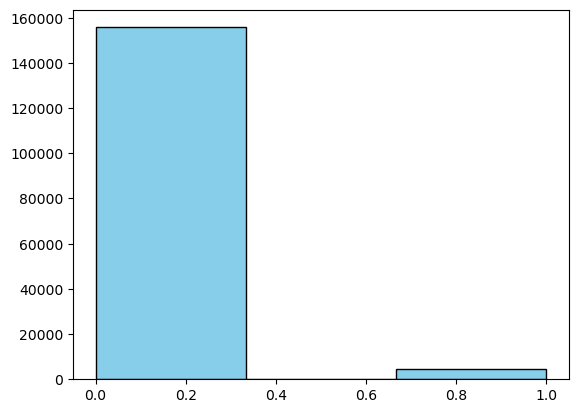

In [346]:
plt.hist(stata_cw_1stmerge["bad match"].astype(int) , bins=3, color='skyblue', edgecolor='black')